# Data Project

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
pd.set_option('display.float_format', lambda x: '%.2f' % x) # formating
from matplotlib.dates import date2num

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Introduction


In the following project, we examine Gross Value Added (**GVA**) in different sectors and in total. We employ data from the Danish Statistical Bank (Statistikbanken), implying that we only analyze data from Denmark.\
Furthermore we examine the construction sector. Here we compare GVA with construction costs and employment in order to analyze whether or not there is a positive or negative correlation between GVA, construction costs and employment. \
Additionally we examine this sector to see if certain industries are more volatile than others and if this seems to be the case, we would like to examine such an industry. 

# Read and clean data

We import three different datasets from **Danmarks Statistikbank**, namely **Gross Value Added**, **Construction Cost** and **Employment for Construction**. 

In [2]:
# We import three datasets from DST
GVA = DstApi('NABP10') # Gross value added
COST = DstApi('BYG32') # Construction Cost
EMPLOY = DstApi('NABB10') # Employment

# We create tables for each dataset and we display them
summary_GVA = GVA.tablesummary(language='en')
summary_COST = COST.tablesummary(language='en')
summary_EMPLOY = EMPLOY.tablesummary(language='en')
display(summary_GVA)
display(summary_COST)
display(summary_EMPLOY)

Table NABP10: 1-2.1.1 Production
and  generation of income (10a3-grouping) by transaction, industry, price unit and time
Last update: 2023-03-31T08:00:00
Table BYG32: Construction cost index for residential buildings by main index, kind, unit and time
Last update: 2023-03-08T08:00:00
Table NABB10: Employment (10a3-grouping) by socioeconomic status, industry and time
Last update: 2023-03-31T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,10,P1K,P.1 Output,B1N2D,B.1n Net value added,False
1,BRANCHE,15,V,Total,VR_S,"R_S Arts, entertainment and other services",False
2,PRISENHED,2,V,Current prices,LAN,"2010-prices, chained values",False
3,Tid,57,1966,1966,2022,2022,True


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,HINDEKS,2,02,Construction Cost index for one-family houses,03,Construction Cost Index for multi-family houses,False
1,ART,3,1002,Total,1006,Total labour costs,False
2,ENHED,2,100,Index,315,Percentage change compared to previous year,False
3,Tid,83,1940,1940,2022,2022,True


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,SOCIO,4,EMPH_DC,"Hours worked (1,000 hours)",SALM_DC,Employees (number),False
1,BRANCHE,15,V,Total,VR_S,"R_S Arts, entertainment and other services",False
2,Tid,57,1966,1966,2022,2022,True


## Defining parameters, renaming variables, filtering & sorting datasets

In the **Gross Value Added** dataset we filter "*Gross Value Added*" in **TRANSAKT**, "*Total*" "*Construction*" and "*Public administration, education and health*" in **BRANCHE**, "*2010-prices, chained values*" in **PRISENHED** and *1988-2022* in **Tid**. \
In the **Consruction Cost** dataset we filter "*Construction Cost index for one-family houses*" in **HINDEKS**, "*Total*" in **ART** and "*Percentage change compared to previous year*" in **INDEX**. \
In the **Employment** dataset we filter "*Employment (number)*" in **SOCIO**, "*Construction*" in **BRANCHE** and *1989-2022* in **Tid**. 

At first we can compare **Gross Value Added** in the **Construction industry** to **Public administration, education and health** and the total **Gross Value Added**. After that we look further into the **Construction industry**. 

In [3]:
# First we define the parameters
pars_GVA = GVA._define_base_params(language='en')
pars_COST = COST._define_base_params(language='en')
pars_EMPLOY = EMPLOY._define_base_params(language='en')

# Next we filter the data into three datasets
variables = pars_GVA['variables'] # Returns a view, that we can edit
variables[0]['values'] = ['B1GD']
variables[1]['values'] =['V','VF', 'VO_Q']
variables[2]['values'] = ['LAN']
variables[3]['values'] = ['>1988<=2022']

variables = pars_COST['variables'] # Returns a view, that we can edit
variables[0]['values'] = ['02']
variables[1]['values'] =['1002']
variables[2]['values'] = ['315']
variables[3]['values'] = ['>1989<=2022']

variables = pars_EMPLOY['variables'] # Returns a view, that we can edit
variables[0]['values'] = ['EMPM_DC']
variables[1]['values'] =['VF']
variables[2]['values'] = ['>1989<=2022']

# Loads the api, creates a new index, renames and sorts the data
GVA_api = GVA.get_data(params=pars_GVA)
GVA_api.reset_index(inplace = True, drop = True)
GVA_api = GVA_api.apply(pd.to_numeric, errors='ignore')
GVA_api.rename(columns = {'INDHOLD': 'GVA'}, inplace=True)
GVA_api.sort_values(by=['BRANCHE', 'TID'], inplace=True)

# Loads the api, creates a new index, renames and sorts the data
COST_api = COST.get_data(params=pars_COST)
COST_api.reset_index(inplace = True, drop = True)
COST_api = COST_api.apply(pd.to_numeric, errors='ignore')
COST_api.rename(columns = {'INDHOLD': 'Pct. Change in cost'}, inplace=True)
COST_api.sort_values(by=['TID'], inplace=True)

# Loads the api, creates a new index, renames and sorts the data
EMPLOY_api = EMPLOY.get_data(params=pars_EMPLOY)
EMPLOY_api.reset_index(inplace = True, drop = True)
EMPLOY_api = EMPLOY_api.apply(pd.to_numeric, errors='ignore')
EMPLOY_api.rename(columns = {'INDHOLD': 'Employment'}, inplace=True)
EMPLOY_api.sort_values(by=['TID'], inplace=True)

# Defines the datasets to specific graphs
total_plot = GVA_api[GVA_api.BRANCHE.str.contains('Total') == True]
constr_plot = GVA_api[GVA_api.BRANCHE.str.contains('F Construction') == True]
public_plot = GVA_api[GVA_api.BRANCHE.str.contains('O_Q Public administration, education and health') == True]

# Defines the specifications of the graphs
total_plot['Pct. Change'] = total_plot['GVA'].pct_change(periods=1)*100
constr_plot['Pct. Change'] = constr_plot['GVA'].pct_change(periods=1)*100
public_plot['Pct. Change'] = public_plot['GVA'].pct_change(periods=1)*100



/var/folders/qn/m3hbpy256cs_8mfcpffzgvzr0000gn/T/ipykernel_54417/2811028443.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_plot['Pct. Change'] = total_plot['GVA'].pct_change(periods=1)*100
/var/folders/qn/m3hbpy256cs_8mfcpffzgvzr0000gn/T/ipykernel_54417/2811028443.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constr_plot['Pct. Change'] = constr_plot['GVA'].pct_change(periods=1)*100
/var/folders/qn/m3hbpy256cs_8mfcpffzgvzr0000gn/T/ipykernel_54417/2811028443.py:53: SettingWithCopyWarning: 


# Merge datasets to graphs

In [4]:
# Here we merge the datasets to the graphs 
merge_employ = pd.merge(constr_plot, EMPLOY_api, on='TID').drop('BRANCHE_y', axis=1)
merge_employ.head(5)

,TRANSAKT,BRANCHE_x,PRISENHED,TID,GVA,Pct. Change,SOCIO,Employment
0,B.1g Gross value added,F Construction,"2010-prices, chained values",1990,71122,-10.17,Employment (number),167536
1,B.1g Gross value added,F Construction,"2010-prices, chained values",1991,67631,-4.91,Employment (number),158232
2,B.1g Gross value added,F Construction,"2010-prices, chained values",1992,68059,0.63,Employment (number),153715
3,B.1g Gross value added,F Construction,"2010-prices, chained values",1993,59842,-12.07,Employment (number),148435
4,B.1g Gross value added,F Construction,"2010-prices, chained values",1994,63482,6.08,Employment (number),154387


In [5]:
# Here we merge the datasets to the graphs 
merge_cost = pd.merge(constr_plot, COST_api, on='TID')
merge_cost.head(5)

,TRANSAKT,BRANCHE,PRISENHED,TID,GVA,Pct. Change,HINDEKS,ART,ENHED,Pct. Change in cost
0,B.1g Gross value added,F Construction,"2010-prices, chained values",1990,71122,-10.17,Construction Cost index for one-family houses,Total,Percentage change compared to previous year,4.90
1,B.1g Gross value added,F Construction,"2010-prices, chained values",1991,67631,-4.91,Construction Cost index for one-family houses,Total,Percentage change compared to previous year,3.50
2,B.1g Gross value added,F Construction,"2010-prices, chained values",1992,68059,0.63,Construction Cost index for one-family houses,Total,Percentage change compared to previous year,2.80
3,B.1g Gross value added,F Construction,"2010-prices, chained values",1993,59842,-12.07,Construction Cost index for one-family houses,Total,Percentage change compared to previous year,1.80
4,B.1g Gross value added,F Construction,"2010-prices, chained values",1994,63482,6.08,Construction Cost index for one-family houses,Total,Percentage change compared to previous year,2.50


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

In [6]:
# Descriptive statistic of GVA
GVA_api.groupby(by=['BRANCHE'])['GVA'].describe()


,count,mean,std,min,25%,50%,75%,max
BRANCHE,,,,,,,,
F Construction,34.00,78884.62,9930.01,59842.00,71181.75,78850.00,86260.00,101002.00
"O_Q Public administration, education and health",34.00,350392.53,35541.33,288214.00,323436.00,350355.00,379946.75,399037.00
Total,34.00,1505062.59,231774.34,1101580.00,1332590.25,1536286.00,1623845.75,1960651.00


Here we see that there is a difference in the level of "**Construction**" and "**Public administration, education and health**". \
Public administration, education and health is at a significantly higher level than Construction. 

In [7]:
# Descriptive statistic of pct. change in cost in the construction industry
merge_cost.groupby(by=['BRANCHE'])['Pct. Change in cost'].describe()

,count,mean,std,min,25%,50%,75%,max
BRANCHE,,,,,,,,
F Construction,33.00,2.81,1.91,-0.20,1.80,2.60,3.50,10.40


We see that the percentage change in **Construction** costs generally have been positive in the dataset which we cover.
In other words, the spending on construction has been steadily increasing in the period 1940-2022 - which is the period covered by our dataset - with a *lower quartile value* of **1.80%**, an *upper quartile value* of **3.50%**, and a *mean value* of **2.81%**

In [8]:
# Descriptive statistic of employment in the construdction industry
merge_employ.groupby(by=['BRANCHE_x'])['Employment'].describe()

,count,mean,std,min,25%,50%,75%,max
BRANCHE_x,,,,,,,,
F Construction,33.00,176389.91,16645.43,148435.00,165344.00,174542.00,186247.00,211078.00


We see that the **Construction** industry has a *mean employment* of approximately 176,000 persons, with a *lower quartile value* of 165,344 and an *upper quartile value* of 186,247

# Should we show this in percentage changes as well?

# Plotting

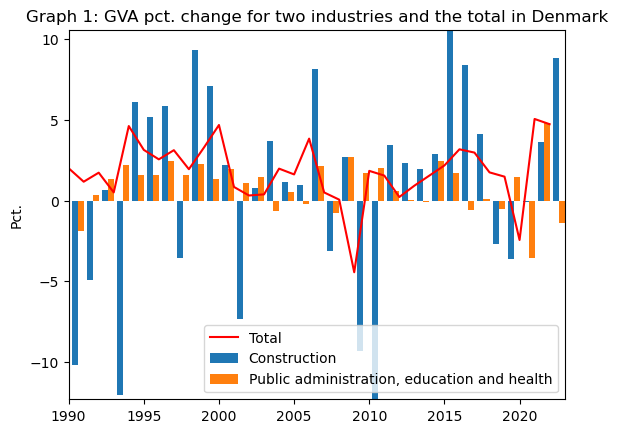

In [9]:
# Creates a figure with both a plot and a bar
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(total_plot['TID'],total_plot['Pct. Change'],color='r',label='Total')
ax.bar(height=constr_plot['Pct. Change'],x=constr_plot['TID']+0.4, width=0.4, label='Construction')
ax.bar(height=public_plot['Pct. Change'],x=public_plot['TID']+0.8, width=0.4, label='Public administration, education and health')
ax.margins(0,0)
ax.legend()
plt.ylabel('Pct.')
plt.title('Graph 1: GVA pct. change for two industries and the total in Denmark')
plt.show()

We see that **Construction** as an industry is more volatile than the average of the industries in the dataset. That is, when the **Gross Value Added** fluctuates due to frictions in the economy, **Construction** is far more volatile than other industries, including **Public Administration and Health** which we choose to focus on in this instance. 

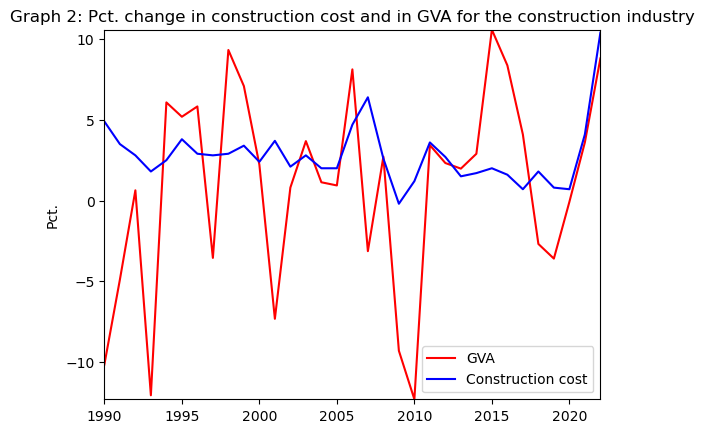

In [10]:
# Creates a figure with two plots
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(merge_cost['TID'],merge_cost['Pct. Change'],color='r',label='GVA')
ax.plot(merge_cost['TID'],merge_cost['Pct. Change in cost'],color='b',label='Construction cost')
ax.margins(0,0)
ax.legend()
plt.ylabel('Pct.')
plt.title('Graph 2: Pct. change in construction cost and in GVA for the construction industry')
plt.show()

Here we see the correlation between the cost of construction, and the added value from construction as an industry to the economy. From the plot we see that the cost of construction have been steadily increasing from 1990 to 2020, with an approximate average percentage change increase of 3-4% per year. Conversely we see that the **Gross Value Added** from the construction industry has been fluctuating substantially in the time period, especially during the financial crisis of 2008-2009. 

Finally we see that there seems to be a correlation during the Covid-19 pandemic, where we saw an increase in construction costs globally, as both the **Gross Value Added** and the costs of construction percentage wise increase rapidly during this period.

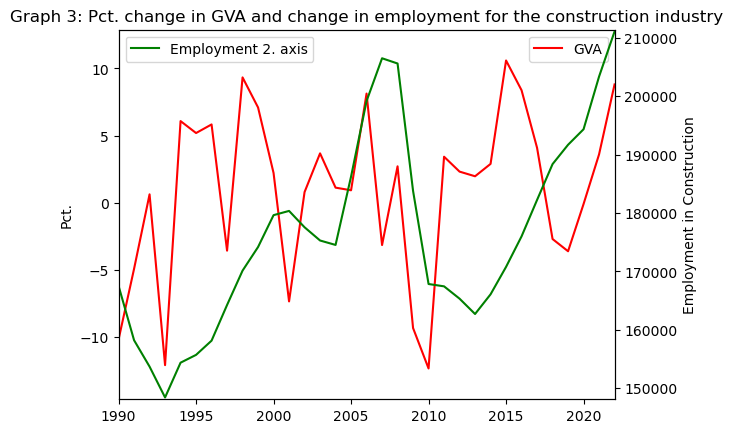

In [11]:
# Creates a figure with two plots
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
ax1.plot(merge_employ['TID'],merge_employ['Pct. Change'],color='r',label='GVA')
ax2.plot(merge_employ['TID'],merge_employ['Employment'],color='g',label='Employment 2. axis')
ax1.margins(0,0.1)
ax2.margins(0,0.005)
ax1.legend()
ax2.legend()
ax1.set_ylabel('Pct.')
ax2.set_ylabel('Employment in Construction')
plt.title('Graph 3: Pct. change in GVA and change in employment for the construction industry')
plt.show()

From **Graph 3** we see the same development in the percentage change of **GVA** from the construction industry as in **Graph 2**.

However, we now see the change in employment in the construction industry plotted besides it. There seems to be no clear correlation of the amount of employed in the industry, and the percentage change in **GVA** for the construction industry.

Having said that, there seems to be a small indication of a correlation in the period of the Covid-19 pandemic, possible due to the same reasons as explained for **Graph 2**

# Conclusion

From **Graph 1** we see that the **Construction** industry is much more volatile than the industry of **Public Administration, Education and Health**. The industry of **Construction** seems to follow the changes in the total GVT more than the industry of **Public Administration, Education and Health**.

We look further into the **Construction** industry, more specifically *construction cost* and *employment*, to see if there are any correlations with GVA in the industry. 

**Graph 2** shows us that the pct. change in *construction cost* is not as volatility as the pct. change in **GVA** for the industry. There is not a clear correlation between the *construction cost* and **GVA** in the period, but you could argue that there is some sort of correlation in some specific years as 2005 to 2011 and specifically 2020 to 2022. 

**Graph 3** shows us that *employment* in the *construction industry* has increased from 1990 to 2022, but with both increasing and decreasing outliers, e.g., before the financial crisis in 2008 and after. There is no significant correlation between the *employment* and **GVA** in the *construction industry*, which may come as a surprise. We had expected there to be some sort of correlation between the *employment* and **GVA** in the *construction industry*.